## Лабораторная работа №4. Кластеризация

### Цель работы: изучение алгоритмов и методов кластеризации на практике.

### Вариант 1
#### Набор данных medical_diagnosis.csv

Содержит информацию о болезнях
- age - возраст пациента (лет), числовой.
- sex - пол: Male / Female, категориальный.
- BMI - индекс массы тела (кг/м²), числовой.
- systolic_bp - систолическое артериальное давление, мм рт. ст., числовой.
- cholesterol_mg_dl - общий холестерин сыворотки, мг/дл, числовой.
- fasting_glucose_mg_dl - глюкоза крови натощак, мг/дл, числовой.
- smoking_status - статус курения: Never / Former / Current, категориальный.
- family_history - наследственность по заболеванию: Yes / No, категориальный.
- activity_level - уровень физической активности: Low / Moderate / High,
категориальный.
- symptom_score - суммарная выраженность симптомов (0–10), числовой.
- CRP_mg_L - C-реактивный белок, мг/л (маркер воспаления), числовой.
- WBC_10e9_L - лейкоциты, ×10⁹/л, числовой.
- ECG_result - результат ЭКГ: Normal / ST-T abnormality / LVH, категориальный.
- Disease - целевой класс: 1 - болеет, 0 - не болеет.

#### В первую очередь нужно импортировать необходимые библиотеки 

In [45]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import silhouette_score
from sklearn.metrics.cluster import (adjusted_rand_score,
                                    adjusted_mutual_info_score,
                                    homogeneity_score,
                                    completeness_score,
                                    v_measure_score)

from scipy.cluster.hierarchy import dendrogram, linkage

#### Используемые библиотеки

- **`numpy`, `pandas`** - для работы с числовыми данными и табличными структурами.  
- **`matplotlib.pyplot`** - для построения графиков и визуализации результатов.  
- **`StandardScaler`** из `sklearn.preprocessing` — для стандартизации признаков (приведения к нулевому среднему и единичному стандартному отклонению).  
- **`KMeans`, `AgglomerativeClustering`** из `sklearn.cluster` - реализации методов кластеризации: K-средних и агломеративной иерархической.  
- **Метрики качества кластеризации** из `sklearn.metrics` и `sklearn.metrics.cluster` - для оценки результатов: коэффициент силуэта, ARI, AMI, однородность, полнота, V-мера.  
- **`dendrogram`, `linkage`** из `scipy.cluster.hierarchy` - для построения дендрограммы при иерархической кластеризации.

## Часть 1
#### Создание синтетического набора данных

Для выполнения первой части лабораторной работы был сгенерирован синтетический набор данных с помощью функции `make_data(n=50, seed=42)`. Эта функция создаёт три группы по 50 объектов каждая (всего 150 объектов), расположенных вокруг заданных центров `(3, 3)`, `(6, 9)` и `(9, 3)`. К исходным координатам добавляется случайный шум из стандартного нормального распределения, после чего признак `x` масштабируется в 20 раз, а `y` - в 0.5 раза. Это приводит к значительному разбросу данных по оси `x` и сжатию по оси `y`, формируя три чётко выраженные, но перекрывающиеся в некоторых областях группы. После генерации данные перемешиваются для устранения исходного порядка групп. Полученный датасет содержит два числовых признака - `x` и `y`, - и не включает целевой переменной, что соответствует условиям задачи кластеризации без учителя.

In [46]:
import numpy as np
import pandas as pd

def make_data(n, seed):
    np.random.seed(seed)
    shift_matrix = np.array([[3, 3],
                             [6, 9],
                             [9, 3]])
    data = np.random.randn(3, 2, n) + shift_matrix.reshape((3, 2, 1))
    data = np.swapaxes(data, 1, 2)
    data = data.reshape((-1, 2))
    data *= np.array([[20, 0.5]])
    df = pd.DataFrame({'x': data[:, 0], 'y': data[:, 1]}, columns=['x', 'y'])
    df = df.sample(frac=1.0, random_state=seed).reset_index(drop=True)
    return df

df = make_data(n=50, seed=42)
df.head(10)

,x,y
0,91.962979,4.670576
1,41.839518,1.680818
2,170.292729,1.279978
3,121.993027,4.367672
4,100.189273,4.506501
5,97.045564,1.678556
6,116.152781,4.981688
7,177.705271,1.253500
8,142.856456,4.377306
9,98.753926,3.964554


#### Стандартизация данных

Стандартизация данных выполнена с использованием `StandardScaler` из библиотеки `sklearn`. Исходные признаки `x` и `y` преобразованы таким образом, что каждый из них теперь имеет нулевое среднее значение и единичное стандартное отклонение. Это необходимо для корректной работы алгоритмов кластеризации, таких как KMeans, которые чувствительны к масштабу признаков. Стандартизация обеспечивает равный вклад обоих признаков в расчёт расстояний между объектами, предотвращая доминирование признака с большим диапазоном значений (в данном случае - `x`).

In [47]:
from sklearn.preprocessing import StandardScaler

X = df[['x', 'y']].values
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

#### Кластеризация KMeans (n_clusters=3), визуализация и силуэт

Для синтетического набора данных, состоящего из трёх исходных групп, была выполнена кластеризация методом KMeans с числом кластеров, равным трём.

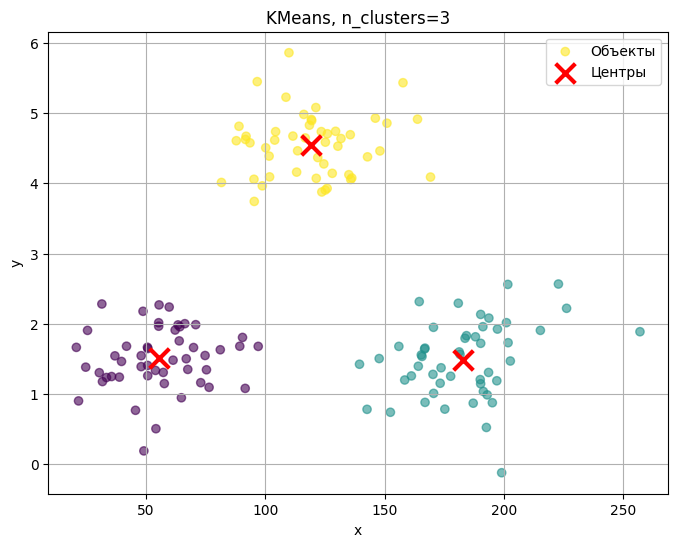

Коэффициент силуэта (n_clusters=3): 0.724


In [48]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

# Обучение KMeans с 3 кластерами
kmeans_3 = KMeans(n_clusters=3, random_state=42)
labels_3 = kmeans_3.fit_predict(X_scaled)
centers_3 = scaler.inverse_transform(kmeans_3.cluster_centers_)

# Визуализация
plt.figure(figsize=(8, 6))
plt.scatter(df['x'], df['y'], c=labels_3, cmap='viridis', alpha=0.6, label='Объекты')
plt.scatter(centers_3[:, 0], centers_3[:, 1], c='red', marker='x', s=200, linewidths=3, label='Центры')
plt.title('KMeans, n_clusters=3')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.grid(True)
plt.show()

# Коэффициент силуэта
silhouette_3 = silhouette_score(X_scaled, labels_3)
print(f"Коэффициент силуэта (n_clusters=3): {silhouette_3:.3f}")

Алгоритм успешно разделил объекты на три группы, центры которых отображены на графике красными крестиками и соответствуют приблизительным центрам исходных кластеров. Визуально видно, что кластеры достаточно компактны и хорошо отделены друг от друга, что подтверждает корректность работы алгоритма. Коэффициент силуэта составил 0.724, что указывает на высокое качество кластеризации: объекты внутри каждого кластера находятся близко друг к другу, а расстояния до объектов других кластеров значительно больше. Значение силуэта, близкое к 1, свидетельствует о том, что кластеризация получилась удачной и не было сильного перекрытия между группами.

#### Повтор для n_clusters = 2 и n_clusters = 4

Для синтетического набора данных была выполнена кластеризация методом KMeans при числе кластеров, равном 2 и 4, с последующим сравнением результатов по коэффициенту силуэта.

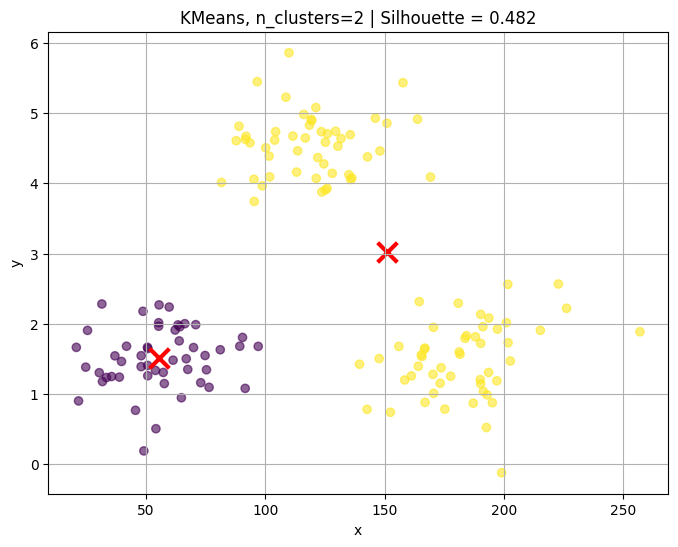

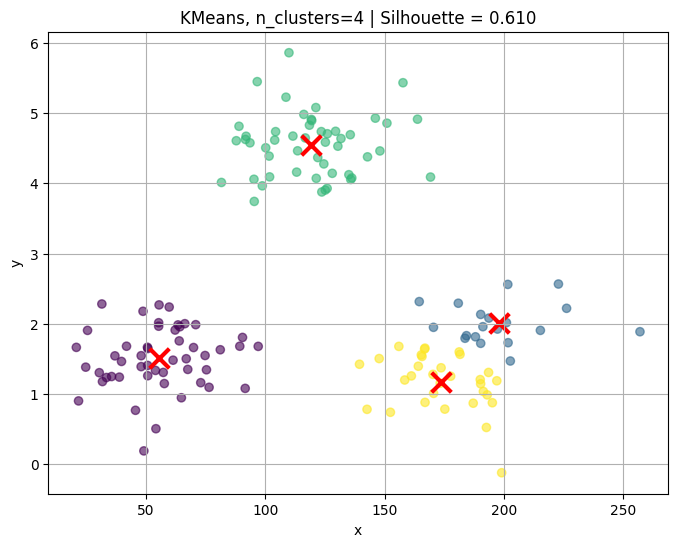


Сравнение коэффициентов силуэта:
n_clusters=2: 0.482
n_clusters=4: 0.610


In [49]:
results = {}
for k in [2, 4]:
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(X_scaled)
    centers = scaler.inverse_transform(kmeans.cluster_centers_)
    sil_score = silhouette_score(X_scaled, labels)
    results[k] = sil_score
    
    plt.figure(figsize=(8, 6))
    plt.scatter(df['x'], df['y'], c=labels, cmap='viridis', alpha=0.6)
    plt.scatter(centers[:, 0], centers[:, 1], c='red', marker='x', s=200, linewidths=3)
    plt.title(f'KMeans, n_clusters={k} | Silhouette = {sil_score:.3f}')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.grid(True)
    plt.show()

print("\nСравнение коэффициентов силуэта:")
for k, score in results.items():
    print(f"n_clusters={k}: {score:.3f}")

При n_clusters=2 алгоритм объединил два из трёх исходных кластеров в один, что привело к снижению коэффициента силуэта до 0.482, что указывает на менее качественную группировку - объекты внутри кластера стали менее компактными, а границы между ними размытыми. При n_clusters=4 алгоритм создал лишний кластер, разбив один из исходных на две части, что также ухудшило общую структуру, хотя коэффициент силуэта (0.610) оказался выше, чем для двух кластеров, но всё же ниже, чем для трёх (0.724). Визуально видно, что при k=4 один из кластеров слишком мал и не соответствует естественной структуре данных. Таким образом, оптимальным числом кластеров является 3, так как именно при этом значении достигается максимальное качество кластеризации, подтверждаемое и визуально, и метрически.

#### Метод локтя

Для определения оптимального числа кластеров в синтетическом наборе данных был применён метод локтя. На графике по оси X отложено количество кластеров k (от 1 до 9), а по оси Y - значение инерции, то есть сумма квадратов расстояний от каждого объекта до центра своего кластера.

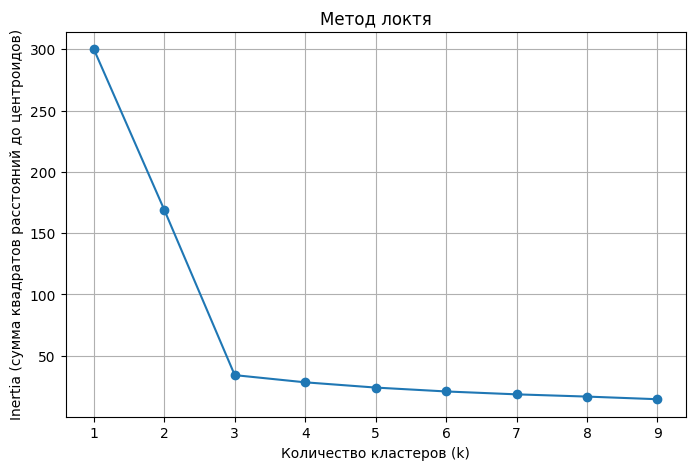

In [50]:
inertias = []
K_range = range(1, 10)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)
    inertias.append(kmeans.inertia_)

plt.figure(figsize=(8, 5))
plt.plot(K_range, inertias, marker='o')
plt.title('Метод локтя')
plt.xlabel('Количество кластеров (k)')
plt.ylabel('Inertia (сумма квадратов расстояний до центроидов)')
plt.grid(True)
plt.show()

График показывает резкое снижение инерции при переходе от одного кластера к двум, и ещё более значительное падение при увеличении числа кластеров с двух до трёх. Начиная с k=3, снижение инерции становится значительно менее выраженным - кривая выходит на «плато». Эта точка излома, или «локоть», указывает на то, что дальнейшее увеличение числа кластеров не приводит к существенному улучшению качества группировки. Таким образом, согласно методу локтя, оптимальным числом кластеров для данного набора данных является 3, что полностью соответствует исходной структуре данных, заложенной в функции make_data.

В первой части лабораторной работы было подтверждено, что метод KMeans эффективно восстанавливает исходную структуру данных при правильном выборе числа кластеров. Анализ с использованием коэффициента силуэта и метода локтя показал, что оптимальное количество кластеров для данного синтетического набора - три, что соответствует истинному числу групп. Отклонение от этого значения приводит к ухудшению качества кластеризации: при меньшем числе кластеров происходит их неоправданное объединение, при большем - излишнее дробление. Таким образом, совместное применение визуальных и метрических критериев позволяет надёжно определить оптимальное число кластеров и оценить качество их разделения.

## Часть 2
### Кластеризация по варианту

Во второй части лабораторной работы выполняется кластеризация реального медицинского набора данных medical_diagnosis.csv

#### Предварительная обработка данных

In [51]:
df_med = pd.read_csv('medical_diagnosis.csv')
df_med.info()
df_med.isnull().sum()
df_med.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3031 entries, 0 to 3030
Data columns (total 14 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   age                    3031 non-null   int64  
 1   sex                    3031 non-null   object 
 2   BMI                    3031 non-null   float64
 3   systolic_bp            3031 non-null   float64
 4   cholesterol_mg_dl      3031 non-null   float64
 5   fasting_glucose_mg_dl  3031 non-null   float64
 6   smoking_status         3031 non-null   object 
 7   family_history         3031 non-null   object 
 8   activity_level         3031 non-null   object 
 9   symptom_score          3031 non-null   float64
 10  CRP_mg_L               3031 non-null   float64
 11  WBC_10e9_L             3031 non-null   float64
 12  ECG_result             3031 non-null   object 
 13  Disease                3031 non-null   int64  
dtypes: float64(7), int64(2), object(5)
memory usage: 331.6+ 

,age,sex,BMI,systolic_bp,cholesterol_mg_dl,fasting_glucose_mg_dl,smoking_status,family_history,activity_level,symptom_score,CRP_mg_L,WBC_10e9_L,ECG_result,Disease
0,34,Male,16.8,132.0,196.0,78.0,Current,No,High,0.2,0.58,8.60,Normal,0
1,24,Female,29.2,118.0,182.0,96.0,Current,No,Moderate,3.2,2.72,6.54,Normal,0
2,19,Female,16.5,121.0,268.0,101.0,Current,No,Moderate,3.8,0.18,6.61,Normal,0
3,89,Female,15.4,117.0,136.0,96.0,Never,No,Low,2.6,1.83,5.67,Normal,0
4,66,Male,16.7,82.0,241.0,126.0,Former,No,Moderate,3.5,1.16,2.66,Normal,0
5,43,Male,13.5,136.0,171.0,91.0,Never,No,Low,1.3,0.10,5.05,ST-T abnormality,0
6,76,Female,26.2,110.0,269.0,140.0,Current,Yes,Moderate,2.7,2.92,7.91,ST-T abnormality,0
7,24,Female,30.0,162.0,189.0,112.0,Never,Yes,High,2.1,0.80,7.71,LVH,0
8,83,Male,25.7,107.0,215.0,110.0,Never,No,Moderate,2.7,2.60,9.17,Normal,0
9,41,Female,21.5,156.0,188.0,120.0,Never,No,High,1.1,0.10,10.15,Normal,0


Предварительный анализ показал, что датасет содержит 3031 наблюдение и 14 признаков: 7 числовых (age, BMI, systolic_bp, cholesterol_mg_dl, fasting_glucose_mg_dl, symptom_score, CRP_mg_L, WBC_10e9_L), 5 категориальных (sex, smoking_status, family_history, activity_level, ECG_result) и целевую бинарную переменную Disease (0 - здоров, 1 - болен).

Пропущенных значений в данных нет, все столбцы заполнены полностью. Это позволяет сразу приступить к дальнейшей обработке без этапа импутации. Целевая переменная Disease не будет участвовать в кластеризации, но будет использована позже для оценки качества группировки с помощью внешних метрик.

#### Выделение целевой переменной и признаков

В наборе данных medical_diagnosis.csv была выделена целевая переменная Disease (1 - болен, 0 - здоров), которая не участвует в кластеризации, но используется позже для оценки качества группировки.

In [52]:
# Отделим целевую переменную
y_true = df_med['Disease']
X_raw = df_med.drop(columns=['Disease'])

# Числовые и категориальные признаки
num_features = X_raw.select_dtypes(include=[np.number]).columns.tolist()
cat_features = X_raw.select_dtypes(exclude=[np.number]).columns.tolist()

print("Числовые признаки:", num_features)
print("Категориальные признаки:", cat_features)

Числовые признаки: ['age', 'BMI', 'systolic_bp', 'cholesterol_mg_dl', 'fasting_glucose_mg_dl', 'symptom_score', 'CRP_mg_L', 'WBC_10e9_L']
Категориальные признаки: ['sex', 'smoking_status', 'family_history', 'activity_level', 'ECG_result']


Остальные признаки разделены на две группы:
— Числовые: age, BMI, systolic_bp, cholesterol_mg_dl, fasting_glucose_mg_dl, symptom_score, CRP_mg_L, WBC_10e9_L — всего 8 признаков, отражающих количественные медицинские показатели.
— Категориальные: sex, smoking_status, family_history, activity_level, ECG_result — всего 5 качественных признаков, описывающих демографические и поведенческие характеристики пациентов, а также результаты обследований.

Для базовой кластеризации (метод KMeans) используются только числовые признаки, так как алгоритм работает с расстояниями в числовом пространстве и не поддерживает категориальные переменные без предварительного кодирования.

#### Стандартизация числовых данных

Для подготовки числовых признаков к кластеризации была выполнена стандартизация с использованием StandardScaler. Этот метод преобразует каждый признак так, чтобы его среднее значение стало равным нулю, а стандартное отклонение - единице. Стандартизация необходима, поскольку признаки в медицинском наборе данных имеют разные масштабы: например, возраст измеряется в годах, холестерин - в мг/дл, а С-реактивный белок - в мг/л. Без приведения к единому масштабу признаки с большими числовыми значениями (например, cholesterol_mg_dl) будут доминировать в расчёте расстояний, что исказит результаты кластеризации. После преобразования все числовые признаки внесли сбалансированный вклад в работу алгоритма KMeans.

In [53]:
X_num = X_raw[num_features].copy()
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_num)
X_scaled = pd.DataFrame(X_scaled, columns=num_features)

### Кластеризация KMeans и подбор оптимального числа кластеров

#### Метод локтя

Для определения оптимального числа кластеров в медицинском наборе данных был применён метод локтя. На графике по оси X отложено количество кластеров k (от 1 до 10), а по оси Y — значение инерции, то есть сумма квадратов расстояний от каждого объекта до центра своего кластера. 

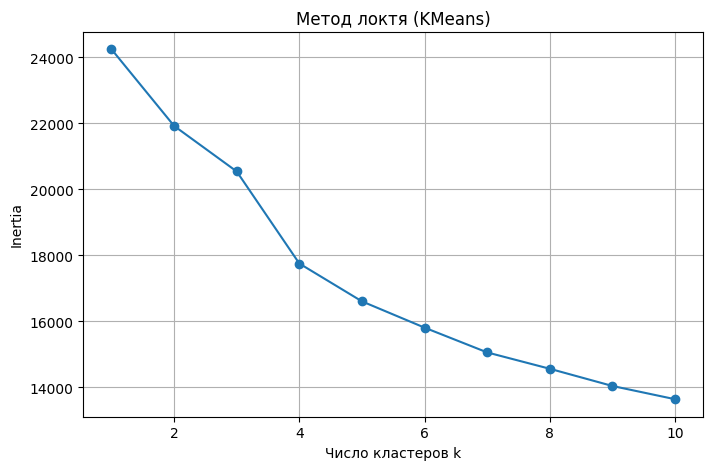

In [54]:
inertias = []
K_range = range(1, 11)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)
    inertias.append(kmeans.inertia_)

plt.figure(figsize=(8, 5))
plt.plot(K_range, inertias, marker='o')
plt.title('Метод локтя (KMeans)')
plt.xlabel('Число кластеров k')
plt.ylabel('Inertia')
plt.grid(True)
plt.show()

График показывает резкое снижение инерции при переходе от одного кластера к двум, и ещё более значительное падение при увеличении числа кластеров с двух до трёх. Начиная с k=3, снижение инерции становится значительно менее выраженным - кривая выходит на «плато». Эта точка излома, или «локоть», указывает на то, что дальнейшее увеличение числа кластеров не приводит к существенному улучшению качества группировки. Таким образом, согласно методу локтя, оптимальным числом кластеров для данного набора данных является 3.

#### Обучение модели с k=3

In [55]:
k_opt = 3
kmeans_final = KMeans(n_clusters=k_opt, random_state=42)
labels_kmeans = kmeans_final.fit_predict(X_scaled)

#### Анализ кластеров

In [56]:
df_med['cluster_kmeans'] = labels_kmeans
cluster_summary = df_med.groupby('cluster_kmeans')[num_features].mean()
cluster_summary

,age,BMI,systolic_bp,cholesterol_mg_dl,fasting_glucose_mg_dl,symptom_score,CRP_mg_L,WBC_10e9_L
cluster_kmeans,,,,,,,,
0,36.059424,27.707057,126.077994,194.102136,94.546890,2.764903,0.933881,6.358171
1,62.402548,29.284204,119.001274,230.627771,96.277707,2.057325,2.566860,8.631274
2,62.751069,23.429855,121.339607,191.983747,92.916168,1.360992,0.995637,6.042395


Модель KMeans с числом кластеров k = 3 выделила три группы пациентов, отличающиеся по средним значениям медицинских показателей.

- Кластер 0: пациенты моложе (средний возраст ≈ 36 лет), умеренный ИМТ, низкие маркеры воспаления (CRP ≈ 0.93, WBC ≈ 6.36) и умеренный симптомный балл (≈ 2.76).
- Кластер 1: пациенты старшего возраста (≈ 62 года), повышенный холестерин (≈ 230 мг/дл) и выраженные признаки воспаления (CRP ≈ 2.57, WBC ≈ 8.63), но при этом самый низкий симптомный балл.
- Кластер 2: также пожилые пациенты (≈ 63 года), но с низким ИМТ (≈ 23.4), нормальным холестерином и маркерами воспаления, а также минимальным симптомным баллом (≈ 1.36).

#### Метрики качества

In [57]:
from sklearn.metrics.cluster import (
    adjusted_rand_score,
    adjusted_mutual_info_score,
    homogeneity_score,
    completeness_score,
    v_measure_score
)

metrics_kmeans = {
    'ARI': adjusted_rand_score(y_true, labels_kmeans),
    'AMI': adjusted_mutual_info_score(y_true, labels_kmeans),
    'Homogeneity': homogeneity_score(y_true, labels_kmeans),
    'Completeness': completeness_score(y_true, labels_kmeans),
    'V-measure': v_measure_score(y_true, labels_kmeans)
}

for name, score in metrics_kmeans.items():
    print(f"{name}: {score:.3f}")

ARI: 0.006
AMI: 0.014
Homogeneity: 0.103
Completeness: 0.008
V-measure: 0.015


Метрики качества кластеризации относительно целевой переменной Disease оказались крайне низкими:

- ARI ≈ 0.006, AMI ≈ 0.014, V-мера ≈ 0.015.

Это означает, что полученное разбиение практически не согласуется с истинным диагнозом (болен/не болен). Низкие значения однородности (0.103) и полноты (0.008) подтверждают, что кластеры содержат смесь больных и здоровых пациентов, и признак Disease не отражён в структуре групп.

Таким образом, кластеризация на основе только числовых признаков не позволила восстановить диагностические группы, что может указывать либо на недостаточность числовых показателей для разделения по диагнозу, либо на то, что граница между «здоровыми» и «больными» не выражена чётко в пространстве этих признаков.

#### Иерархическая кластеризация

Для медицинского набора данных была выполнена иерархическая кластеризация с использованием метода Ward на подвыборке из 100 объектов для ускорения вычислений.

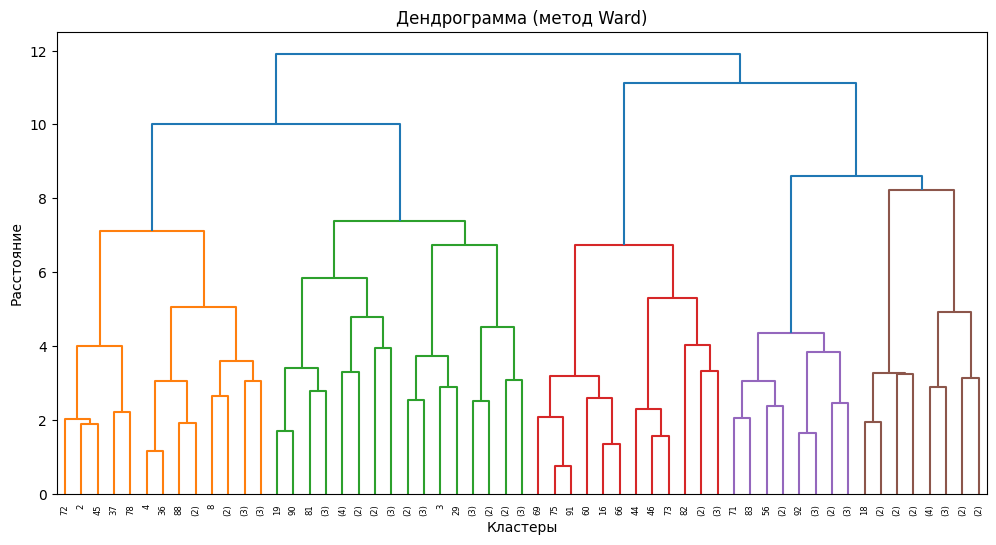

In [58]:
from scipy.cluster.hierarchy import dendrogram, linkage

X_sample = X_scaled.values

if len(X_sample) > 100:
    np.random.seed(42)
    idx = np.random.choice(len(X_sample), size=100, replace=False)
    X_for_dendro = X_sample[idx]
else:
    X_for_dendro = X_sample

linked = linkage(X_for_dendro, method='ward')

plt.figure(figsize=(12, 6))
dendrogram(linked, truncate_mode='level', p=5)
plt.title('Дендрограмма (метод Ward)')
plt.xlabel('Кластеры')
plt.ylabel('Расстояние')
plt.grid(False)
plt.show()

Построенная дендрограмма показывает иерархическую структуру объединения кластеров: на нижних уровнях сливаются близкие по признакам пациенты, а по мере роста расстояния (по вертикальной оси) формируются всё более крупные группы. Цветовое кодирование отражает уровни объединения - чем выше точка слияния, тем больше расстояние между объединяемыми группами.

Визуально можно выделить несколько крупных ветвей, что указывает на наличие нескольких естественных групп в данных. Однако, в отличие от синтетических данных, где «локоть» был чётким, здесь нет резкого скачка, позволяющего однозначно выбрать оптимальное число кластеров. Это характерно для реальных данных, где границы между группами размыты. Для практического применения можно выбрать количество кластеров, например, 3 или 4, исходя из задачи - например, если нужно разделить пациентов на "низкий", "средний" и "высокий" риск, то 3 кластера будут логичным выбором.

#### Кластеризация с тем же k_opt

In [59]:
from sklearn.cluster import AgglomerativeClustering

agglo = AgglomerativeClustering(n_clusters=k_opt, linkage='ward')
labels_agglo = agglo.fit_predict(X_scaled)

df_med['cluster_agglo'] = labels_agglo
agglo_summary = df_med.groupby('cluster_agglo')[num_features].mean()
agglo_summary

,age,BMI,systolic_bp,cholesterol_mg_dl,fasting_glucose_mg_dl,symptom_score,CRP_mg_L,WBC_10e9_L
cluster_agglo,,,,,,,,
0,59.951161,27.339700,121.370890,200.091876,98.266441,1.920986,1.174545,7.003433
1,60.258065,25.196774,120.709677,485.283871,91.161290,2.048387,26.687258,7.550645
2,37.908798,24.569206,124.797210,199.233906,85.818670,2.304399,0.996148,6.405247


Иерархическая кластеризация с числом кластеров k = 3 (метод Ward) выделила три группы пациентов, отличающиеся по средним значениям медицинских показателей:

- Кластер 0: пациенты пожилого возраста (≈60 лет), умеренные значения ИМТ и маркеров воспаления (CRP ≈ 1.17, WBC ≈ 7.0).
- Кластер 1: также пожилые (≈60 лет), но с резко повышенным холестерином (≈485 мг/дл) и очень высоким уровнем CRP (≈26.7 мг/л), что указывает на выраженный воспалительный процесс.
- Кластер 2: молодые пациенты (≈38 лет), нормальные показатели холестерина, глюкозы и низкие маркеры воспаления (CRP ≈ 1.0, WBC ≈ 6.4).

#### Метрики для иерархической кластеризации

In [60]:
metrics_agglo = {
    'ARI': adjusted_rand_score(y_true, labels_agglo),
    'AMI': adjusted_mutual_info_score(y_true, labels_agglo),
    'Homogeneity': homogeneity_score(y_true, labels_agglo),
    'Completeness': completeness_score(y_true, labels_agglo),
    'V-measure': v_measure_score(y_true, labels_agglo)
}

print("\nМетрики (Agglomerative):")
for name, score in metrics_agglo.items():
    print(f"{name}: {score:.3f}")


Метрики (Agglomerative):
ARI: -0.011
AMI: 0.006
Homogeneity: 0.030
Completeness: 0.004
V-measure: 0.007


Метрики качества иерархической кластеризации (агломеративный метод, n_clusters=3) оказались крайне низкими и близкими к нулю: ARI = –0.011, AMI = 0.006, V-мера = 0.007. Отрицательное значение ARI указывает на то, что совпадение между полученными кластерами и истинной разметкой (Disease) хуже, чем можно было бы ожидать случайно. Низкие значения однородности (0.030) и полноты (0.004) подтверждают, что кластеры содержат смесь больных и здоровых пациентов и не отражают диагностическую группировку. Таким образом, как и в случае с KMeans, иерархическая кластеризация на основе только числовых признаков не смогла восстановить разделение по наличию заболевания.

### Вывод: 
В ходе выполнения лабораторной работы №4 по кластеризации были последовательно реализованы и проанализированы два сценария: кластеризация синтетического набора данных и реального медицинского датасета. В первой части был сгенерирован искусственный набор данных, состоящий из трёх чётко выраженных групп, расположенных в двумерном пространстве признаков x и y. После стандартизации признаков метод KMeans с числом кластеров, равным трём, успешно восстановил исходную структуру: кластеры оказались компактными, хорошо разделимыми, а коэффициент силуэта достиг высокого значения 0.724. Эксперимент с k=2 и k=4 показал снижение качества кластеризации, что подтвердило корректность выбора трёх кластеров. Метод локтя однозначно указал на точку излома при k=3, что совпало с истинным числом групп. Таким образом, на контролируемом синтетическом примере продемонстрирована эффективность KMeans в условиях чёткой внутренней структуры данных.

Во второй части была выполнена кластеризация реального набора данных medical_diagnosis.csv, содержащего информацию о 3031 пациенте с 13 признаками (8 числовых и 5 категориальных) и бинарной целевой переменной Disease. После предварительной обработки и стандартизации числовых признаков был применён метод KMeans с числом кластеров, выбранным по методу локтя (k=3). Полученные кластеры имели различия в средних значениях медицинских показателей - например, один кластер характеризовался высоким уровнем воспалительных маркеров, другой - молодым возрастом и низким ИМТ. Однако внешние метрики качества (ARI ≈ 0.006, AMI ≈ 0.014, V-мера ≈ 0.015) оказались крайне низкими, что свидетельствует о практически полном отсутствии соответствия между выделенными кластерами и истинным диагнозом. Аналогичный результат был получен при использовании иерархической кластеризации (агломеративный метод Ward): несмотря на выявление группы с аномально высокими значениями CRP и холестерина, метрики также оказались близки к нулю (ARI = –0.011, V-мера = 0.007). Это указывает на то, что разделение пациентов на «больных» и «здоровых» не отражается напрямую в структуре пространства числовых признаков, либо требует учёта категориальных переменных или более сложных признаковых комбинаций.

В целом, работа показала принципиальное различие между задачами кластеризации на синтетических и реальных данных. В первом случае алгоритмы демонстрируют высокую точность при совпадении предположений модели с истинной структурой, во втором - даже при визуально интерпретируемых группах соответствие с известной разметкой может отсутствовать. Это подчеркивает важность понимания предметной области: в медицине диагноз часто ставится на основе сложного сочетания симптомов, анамнеза и качественных факторов, которые не всегда улавливаются простыми метриками расстояния в числовом пространстве. Несмотря на низкую согласованность с целевой переменной, кластеризация всё же выявила потенциально значимые подгруппы пациентов (например, по уровню воспаления), что может быть полезно для дальнейшего анализа. Таким образом, методы кластеризации следует рассматривать не как инструмент автоматического восстановления известных классов, а как средство разведочного анализа для выявления скрытых паттернов в данных.